# WRF perturbation key results

In this work we compare WRF control output to output in which temperature or moisture have been perturbed around given vertical levels. The aim is to explore linear response functions as described in [Kuang 2010](https://doi.org/10.1175/2009JAS3260.1).

In [1]:
import sys
sys.path.append('git/wrf_lrf_les/analysis/')

from dask.distributed import Client, LocalCluster
import modules.wrf_perturbation as wp
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import datetime
import xarray

print("Report last updated at " + str(datetime.datetime.utcnow()) + ' UTC.')

Report last updated at 2022-12-13 03:21:43.752875 UTC.


In [2]:
cluster = LocalCluster(threads_per_worker=1)
client = Client(cluster)  
print(client)

<Client: 'tcp://127.0.0.1:35641' processes=4 threads=4, memory=18.00 GiB>


## Settings

In [3]:
# Perturbation details.
perts = {'res': ['1 km Chimene'],                       # Dataset names.
         'dir': ['1km_Chimene'],                        # Dataset directories.
         'levels': ['850', '730', '600', '500', '412'], # Perturbed levels in hPa.
         'T': ['0.5', '-0.5'],                          # Temperature perturbations in K day-1.
         'q': ['0.0002', '-0.0002']}                    # Specific humidity perturbations in kg kg-1 day-1.
# perts = {'res': ['1 km', '1 km Chimene', '4 km', 'LES'], # Dataset names.
#          'dir': ['1km', '1km_Chimene', '4km', 'LES'],    # Dataset directories.
#          'levels': ['850', '412'],                       # Perturbed levels in hPa.
#          'T': ['0.5', '-0.5'],                           # Temperature perturbations in K day-1.
#          'q': ['0.0002', '-0.0002']}                     # Specific humidity perturbations in kg kg-1 day-1.

# Input directories with dataset names as keys.
basedir = '/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/'
inputs = wp.input_map(perts=perts, basedir=basedir)
    
# Figure settings.
plt.show()
plt.rcParams['figure.figsize'] = (15,10)  # Figure size for non-facetted plots.
plt.rcParams['font.size'] = 12                   # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False # Don't use offsets in plots.

# The point at which the RCE run ends and control + perturbation runs begin.
runs_start = {'1 km': '2000-03-01', '1 km Chimene': '2000-03-01', '4 km': '2000-03-01', 'LES':  '2000-04-26'} 

# Start and end times for designated RCE periods.
start_time = {'1 km': '2000-04-01', '1 km Chimene': '2000-04-01', '4 km': '2000-04-01', 'LES':  '2000-05-20'}
end_time =   {'1 km': '2000-06-01', '1 km Chimene': '2000-06-01', '4 km': '2000-06-01', 'LES':  '2000-05-27 10:00'}
               
# Pressure levels to plot individually [hPa].
plot_levels = [850, 500, 410, 100] 

## Data input

In [4]:
%%time
wrfvars = wp.read_wrfvars(inputs=inputs, quiet=False)

Reading 1 km Chimene dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/1km_Chimene/RCE/): RCE...
Reading 1 km Chimene dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/1km_Chimene/control/): Control...
Reading 1 km Chimene dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/1km_Chimene/pert_850hPa_T_0.5K/): T 0.5 @850...
Reading 1 km Chimene dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/1km_Chimene/pert_850hPa_T_-0.5K/): T -0.5 @850...
Reading 1 km Chimene dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/1km_Chimene/pert_850hPa_q_0.0002kgkg-1/): q 0.0002 @850...
Reading 1 km Chimene dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/1km_Chimene/pert_850hPa_q_-0.0002kgkg-1/): q -0.0002 @850...
Reading 1 km Chimene dataset (/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/1km_Chimene/pert_730hPa_T_0.5K/): T 0.5 @730...
Reading 1 km Chimene dataset (/g/data/up6/tr

In [5]:
wrfvars = wp.add_mass_flux(wrfvars)

## Setup notes

- Fixed SST (301.15 K).
- Ideal radiative cooling profile as per [Herman and Kuang (2013)](https://doi.org/10.1002/jame.20037).
- Ideal evaporation as per [Chua et al., 2019](http://dx.doi.org/10.1029/2019GL082408).
- Potential temperature and water vapour mixing ratio $q$ are relaxed in the stratosphere (above 160 hPa) to reference RCE profiles, as suggested by [Herman and Kuang (2013)](https://doi.org/10.1002/jame.20037). The reference profile is the profile from the RCEMIP project for the 1 km and 4 km runs, and a the mean 1 km RCE profile over 7 days at the end of the 2000-03 for the LES runs.

Model setup for 1 km Chimene (RCE):
Sea surface temperature (SST):			301.15 K
Surface skin temperature (TSK):			301.15 K
Soil temperature at lower boundary (TMN):	301.15 K
Horizontal grid spacing (DX):			1000.0 m
Horizontal (S-N) grid spacing (DY):		1000.0 m
Horizontal (W-E) domain size:			20 mass points
Horizontal (S-N) domain size:			20 mass points
Vertical domain size:				74 mass points
Maximum geopotential height (model-top):	33174.8 m
Maximum base-state height (on mass points):	32998.8 m
Minimum, mean, maximum between-level distance:	75.0, 451.5, 505.5 m
Model-top pressure:				602.0 Pa
Coriolis sine latitude term (F):		0.0 s-1
Coriolis cosine latitude term (E):		0.0 s-1
Use light nudging on U and V:			False
Ideal evaporation/surface fluxes:		True
Surface wind for ideal surface fluxes:		5.0 m s-1
Constant radiative cooling profile:		True
Relax stratsopheric T and q profiles?		True
Relax U to set profile?				True
RELAX V to set profile?				True
Wind relaxation time:				10800.0 s
Phy

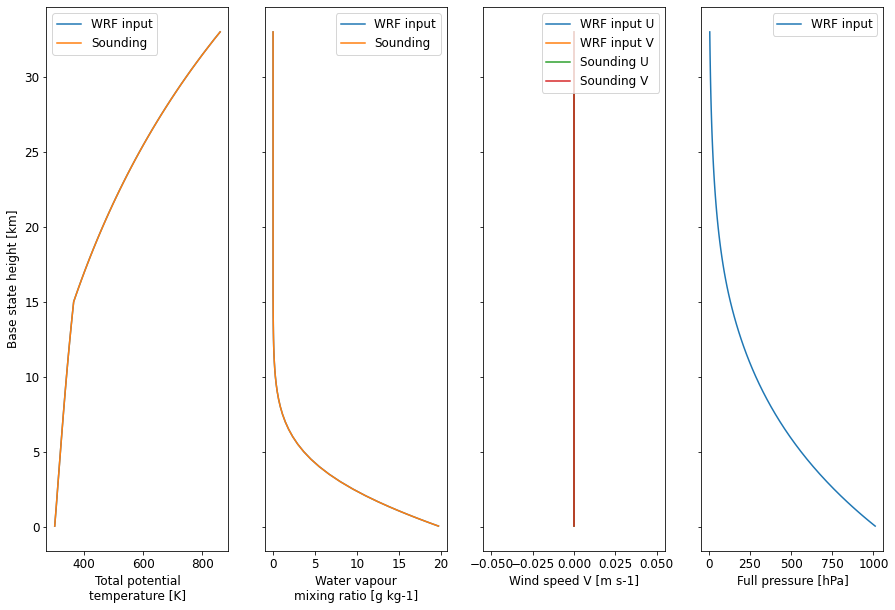

In [6]:
# Figure settings.
wp.model_setups(inputs=inputs)

Here are perturbation settings used in each run:

In [7]:
wp.perturbation_details(inputs)

Perturbation details for 1 km Chimene:
RCE:                          No perturbation.
Control:                      No perturbation.
T 0.5 @850:                   Perturbed T with amplitude 0.5 K day-1 at 850.0 hPa.
T -0.5 @850:                  Perturbed T with amplitude -0.5 K day-1 at 850.0 hPa.
q 0.0002 @850:                Perturbed q with amplitude 0.0002 kg kg-1 day-1 at 850.0 hPa.
q -0.0002 @850:               Perturbed q with amplitude -0.0002 kg kg-1 day-1 at 850.0 hPa.
T 0.5 @730:                   Perturbed T with amplitude 0.5 K day-1 at 730.0 hPa.
T -0.5 @730:                  Perturbed T with amplitude -0.5 K day-1 at 730.0 hPa.
q 0.0002 @730:                Perturbed q with amplitude 0.0002 kg kg-1 day-1 at 730.0 hPa.
q -0.0002 @730:               Perturbed q with amplitude -0.0002 kg kg-1 day-1 at 730.0 hPa.
T 0.5 @600:                   Perturbed T with amplitude 0.5 K day-1 at 600.0 hPa.
T -0.5 @600:                  Perturbed T with amplitude -0.5 K day-1 at 600.0 h

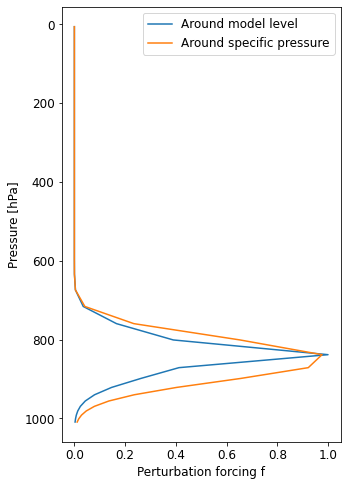

In [11]:
plt.rcParams['figure.figsize'] = (5,8)
wp.compare_perturbation_forcing(dat=wrfvars['1 km Chimene'].sel(Dataset='Control'), p_pert=850, k_pert=10)
plt.rcParams['figure.figsize'] = wp.FIGURE_SIZE

## Radiative-convective equilibrium (RCE)

To determine when the simulations have reached RCE, we look for stabilisation of the precipitable water (PW) field. Here is spatially-averaged PW by time for each simulation. The green highlighted region is the time span over which average profiles are calculated for all runs.

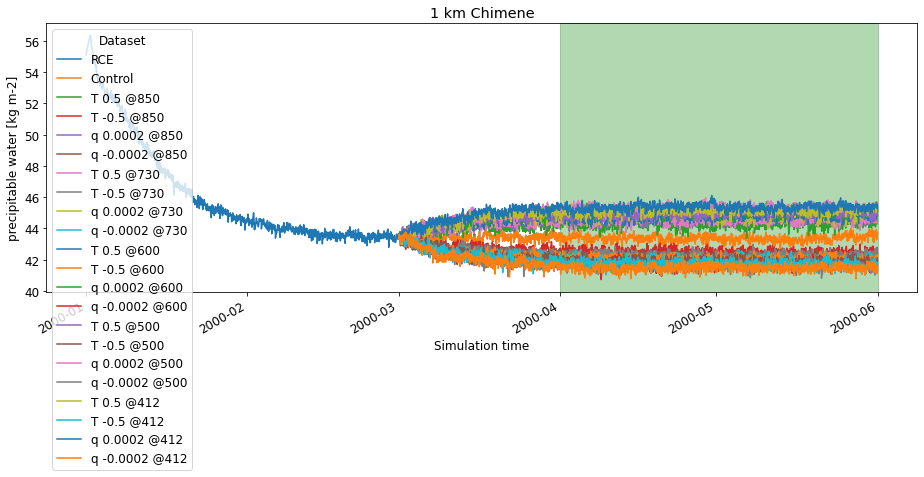

In [12]:
for res in wrfvars.keys():
    wrfvars[res].pw.plot(hue='Dataset', figsize=(13,6))
    plt.axvspan(xmin=start_time[res], xmax=end_time[res], alpha=0.3, color='green')
    plt.title(res)
    plt.tight_layout()
    plt.show()

Remove the 'RCE' dataset, since the reference dataset from here on is 'Control'.

In [13]:
for res in wrfvars.keys():
    wrfvars[res] = wrfvars[res].drop_sel(Dataset='RCE').sel(time=slice(runs_start[res], None))
    del(inputs[res]['RCE'])

## Comparison of mean profiles

In [14]:
%%time
#profs_LES = wrfvars['LES'].sel(time=slice(start_time['LES'], end_time['LES'])).mean('time').load()
#profs_1km = wrfvars['1 km'].sel(time=slice(start_time['1 km'], end_time['1 km'])).mean('time').load()
#profs_4km = wrfvars['4 km'].sel(time=slice(start_time['4 km'], end_time['4 km'])).mean('time').load()
profs_1km_Chimene = wrfvars['1 km Chimene'].sel(time=slice(start_time['1 km'], end_time['1 km'])).mean('time').load()

CPU times: user 3min 32s, sys: 9.09 s, total: 3min 41s
Wall time: 3min 40s


In [138]:
p_1km_Chimene

<xarray.Dataset>
Dimensions:     (Dataset: 21, level: 91)
Coordinates:
  * Dataset     (Dataset) <U14 'Control' 'T 0.5 @850' ... 'q -0.0002 @412'
  * level       (level) int64 1000 990 980 970 960 950 ... 140 130 120 110 100
    Resolution  <U12 '1 km Chimene'
Data variables:
    T           (Dataset, level) float32 -2.701 -2.672 -2.643 ... 81.46 94.04
    rh          (Dataset, level) float64 73.86 76.59 79.5 ... 13.95 5.145 1.263
    qrain       (Dataset, level) float32 7.493e-06 7.506e-06 ... 0.0 0.0
    qcloud      (Dataset, level) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    qice        (Dataset, level) float32 0.0 0.0 0.0 ... 2.016e-14 5.662e-15
    qsnow       (Dataset, level) float32 0.0 0.0 0.0 ... 4.851e-12 1.869e-12
    qgraup      (Dataset, level) float32 4.84e-11 1.209e-10 ... 5.556e-14

In [15]:
variables = ['T', 'rh', 'qrain', 'qcloud', 'qice', 'qsnow', 'qgraup', 'Dataset']

#p_LES = profs_LES[variables].assign_coords({'Resolution': 'LES'})
#p_1km = profs_1km[variables].assign_coords({'Resolution': '1 km'})
#p_4km = profs_4km[variables].assign_coords({'Resolution': '4 km'})
p_1km_Chimene = profs_1km_Chimene[variables].assign_coords({'Resolution': '1 km Chimene'})

#profs = xarray.concat([p_LES, p_1km, p_1km_Chimene, p_4km], dim='Resolution')
profs = xarray.concat([p_1km_Chimene], dim='Resolution')
profs['T'] = profs.T + 300
profs = profs.sel(level=slice(1000, 200))

profs = profs.to_dataframe().reset_index()
qdat = profs[np.logical_or(profs.Dataset == 'Control', np.array([x[0] for x in profs.Dataset]) == 'q')]
Tdat = profs[np.logical_or(profs.Dataset == 'Control', np.array([x[0] for x in profs.Dataset]) == 'T')]
mean_dat = profs[profs.Dataset == 'Control']

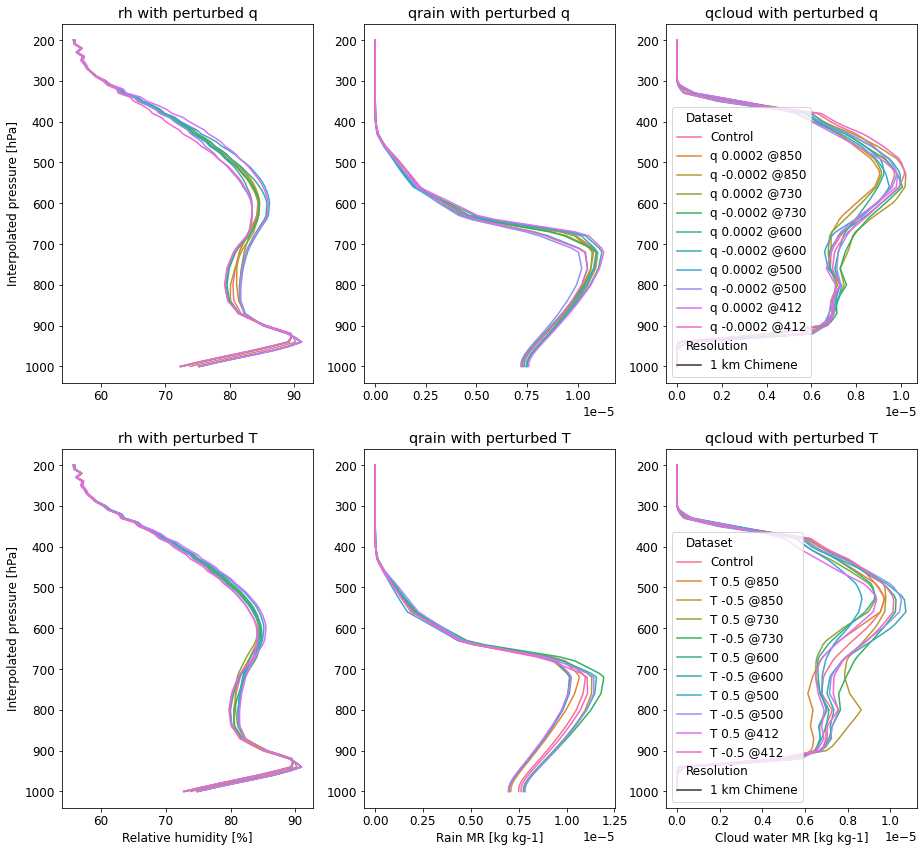

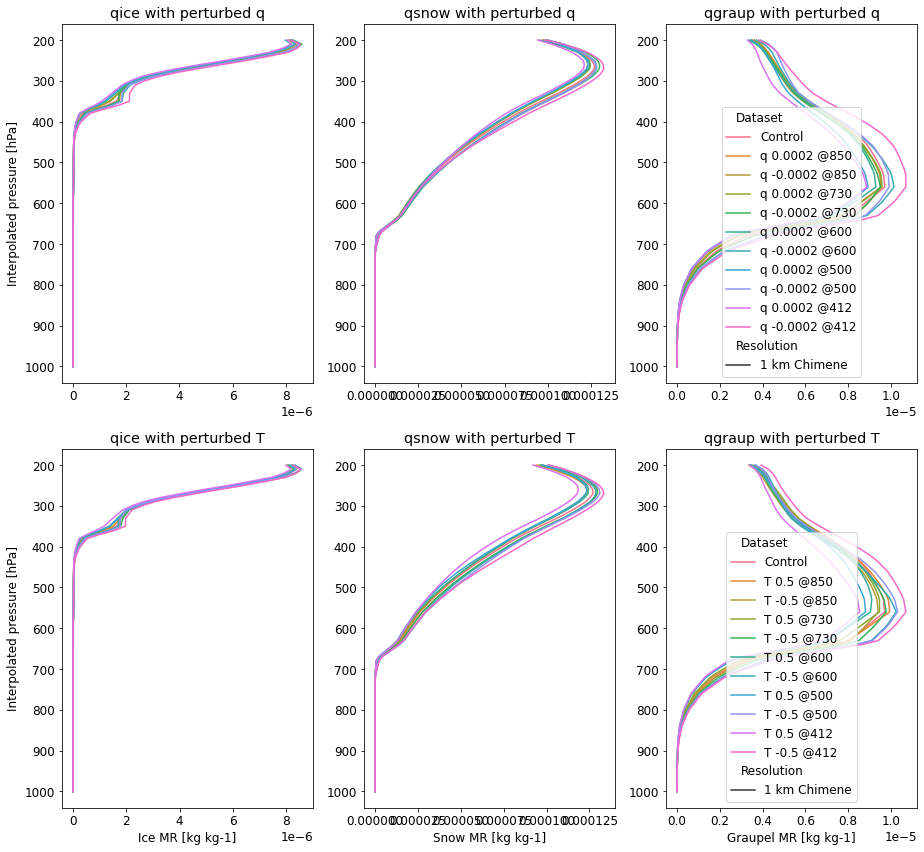

In [18]:
def plot_mean_profs(variables, varnames):
    _, axs = plt.subplots(ncols=len(variables), nrows=2, figsize=(13,12))
    for i, v in enumerate(variables):
        sb.lineplot(data=qdat, x=v, y='level', hue='Dataset', style='Resolution', ax=axs[0,i], legend=(i==len(variables)-1), sort=False, estimator=None)
        sb.lineplot(data=Tdat, x=v, y='level', hue='Dataset', style='Resolution', ax=axs[1,i], legend=(i==len(variables)-1), sort=False, estimator=None)

        for ax in axs[:,i].flat:
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.invert_yaxis()

        axs[1,i].set_xlabel(varnames[i])
        axs[0,i].set_title(f'{v} with perturbed q')
        axs[1,i].set_title(f'{v} with perturbed T')

    axs[0,0].set_ylabel('Interpolated pressure [hPa]')
    axs[1,0].set_ylabel('Interpolated pressure [hPa]')

    plt.tight_layout()
    plt.show()
    
plot_mean_profs(variables=['rh', 'qrain', 'qcloud'],
                varnames=['Relative humidity [%]', 'Rain MR [kg kg-1]', 'Cloud water MR [kg kg-1]'])

plot_mean_profs(variables=['qice', 'qsnow', 'qgraup'],
                varnames=['Ice MR [kg kg-1]', 'Snow MR [kg kg-1]', 'Graupel MR [kg kg-1]'])

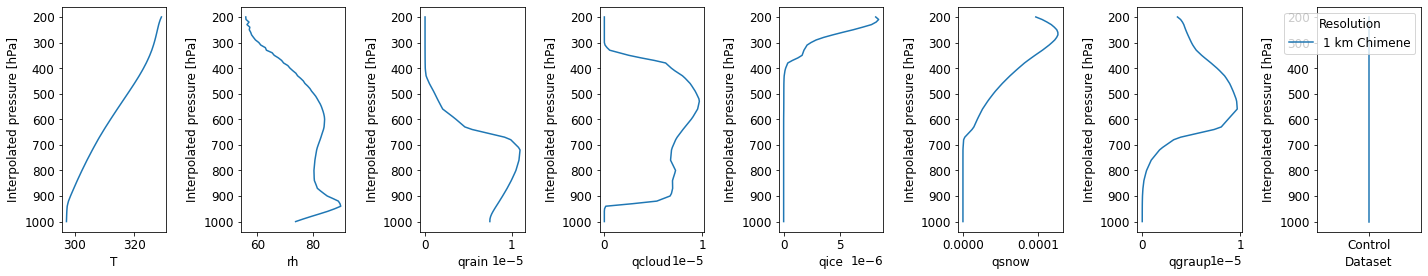

In [20]:
_, axs = plt.subplots(ncols=len(variables), figsize=(20,4))

for i, v in enumerate(variables):
    sb.lineplot(data=mean_dat, x=v, y='level', hue='Resolution', ax=axs[i], legend=(i==len(variables)-1), sort=False, estimator=None)
    axs[i].set_ylabel('Interpolated pressure [hPa]')
    axs[i].set_xlabel(v)
    axs[i].invert_yaxis()
    
plt.tight_layout()
plt.show()

## Mean profiles over RCE period

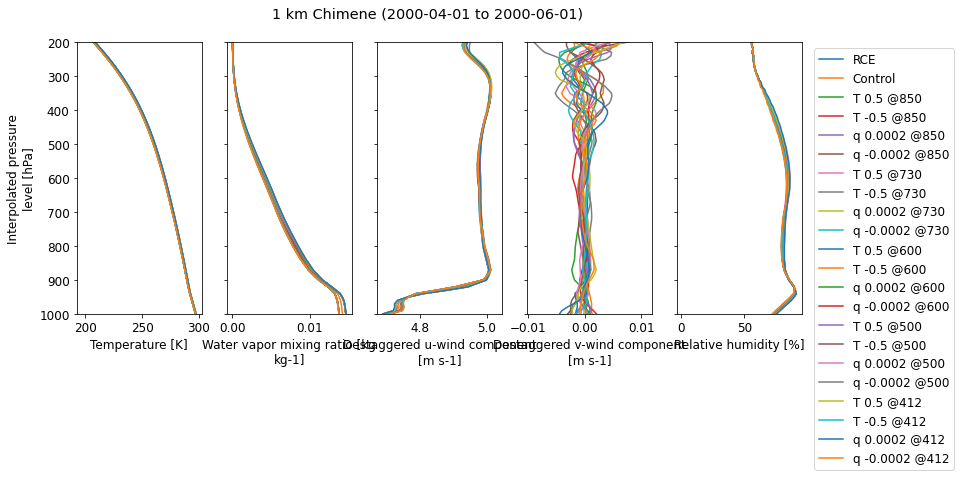

In [8]:
profs = {}
for res in wrfvars.keys():
    profs[res] = wp.mean_profiles(dat=wrfvars[res], start=start_time[res], end=end_time[res], figsize=(13,5), 
                                  title=res + ' (' + str(start_time[res]) + ' to ' + str(end_time[res]) + ')')

## Perturbation differences in averaged RCE profiles

Differences here are defined as `perturbed - control`. The red vertical line shows zero difference.

In [9]:
# Convert q from kg kg-1 to g kg-1.
for res in profs.keys():
    for v in ['q', 'qrain', 'qcloud', 'qice', 'qsnow', 'qgraup']:
        with xarray.set_options(keep_attrs=True):
            profs[res][v] = profs[res][v] * 1000
        profs[res][v].attrs['units'] = 'g kg -1'

In [ ]:
# Read in reference (Kuang 2010) results.
ref_dir = '/g/data/up6/tr2908/LRF_SCM_results/'
refs = {'q_dq': {'var': 'q', 'pert': 'q', 
                 'file': 'SAM/matrix_M_inv/M_inv_sam_q_dqdt_norm_kuang.csv'},
        'q_dT': {'var': 'q', 'pert': 'T', 
                 'file': 'SAM/matrix_M_inv/M_inv_sam_q_dtdt_norm_kuang.csv'},
        'T_dq': {'var': 'tk', 'pert': 'q', 
                 'file': 'SAM/matrix_M_inv/M_inv_sam_t_dqdt_norm_kuang.csv'},
        'T_qT': {'var': 'tk', 'pert': 'T', 
                 'file': 'SAM/matrix_M_inv/M_inv_sam_t_dtdt_norm_kuang.csv'}}

ref_pressures = pd.read_csv(ref_dir+'/pressures', header=None).round(0).astype(int).to_dict()[0]
pert_levels = [412, 850]

res = pd.DataFrame()

for ref, key in refs.items():
    dat = pd.read_csv(ref_dir + key['file'], header=None)
    
    # Column is perturbation level, row is reponse level.
    dat = dat.rename(columns=ref_pressures, index=ref_pressures)
    dat = dat.loc[:,pert_levels]
    
    dat['var'] = key['var']
    dat['perturbed'] = key['pert']
    dat = dat.reset_index()#set_index('var')
    dat = dat.rename(columns={'index': 'level'})
    
    res = pd.concat([res, dat])

res = res.melt(id_vars=['level', 'perturbed', 'var'])
res = res.pivot(index=['level', 'variable', 'perturbed'], columns=['var'])
res.columns = ['q', 'tk']
res = res.reset_index()
res['Dataset'] = 'K10 ' + res.perturbed + ' @' + res.variable.astype(str)
ref = res.drop(columns=['variable']).set_index(['level', 'Dataset'])#.reset_index()
ref = xarray.Dataset.from_dataframe(ref)

In [ ]:
ref.Dataset

In [23]:
diff_set = []

for res in wrfvars.keys():
    for v in ['T', 'q']:
        ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
        diffs = wp.diff_means(profs=profs[res][['tk', 'T', 'q']], control_name='Control')
        neg = [x for x in ds if '-' in x]
        pos_diffs = diffs.drop_sel(Dataset=neg)
        #pos_diffs = pos_diffs.assign_coords({'perturbed': v}).expand_dims('perturbed')
        pos_diffs = pos_diffs.assign_coords({'resolution': res}).expand_dims('resolution')
        diff_set.append(pos_diffs)

diff_set = xarray.merge(diff_set)

# for v in ['T', 'q']:
#     for res in ['LES', '1 km']:
        
#         sub = profs[res].sel(Dataset=ds)
#         _, axs = wp.compare_profiles(profs=sub, figsize=[12,5], variables=['tk','q'],
#                                      neg=[x for x in ds if '-' in x],
#                                      title=(res + ', perturbed ' + v + 
#                                             ' (RCE: ' + str(start_time[res]) + 
#                                             ' to ' + str(end_time[res]) + ')'), 
#                                      loc='best',
#                                      xlims={'tk': [-0.3, 1], 
#                                             'q': [-0.25, 0.5]})
        
#         sb.lineplot(data=ref[ref.perturbed==v], x='tk', y='level', style='Dataset', 
#                     ax=axs[0], sort=False, color='black', legend=True)
#         sb.lineplot(data=ref[ref.perturbed==v], x='q', y='level', style='Dataset', 
#                     ax=axs[1], sort=False, color='black', legend=False)
          
#         axs[0].legend(bbox_to_anchor=(2.81, 0.62))
#         plt.show()

In [25]:
d = diff_set.sel(resolution='1 km Chimene').load()

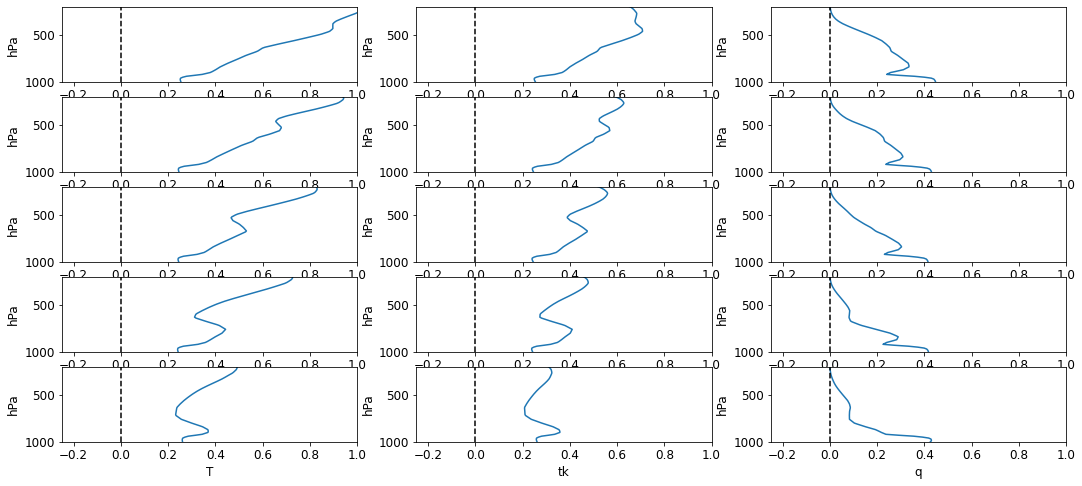

In [27]:
fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(18,8))

for row, lev in enumerate(['412', '500', '600', '730', '850']):
    dset = f'T 0.5 @{lev}'
    pdata = d.sel(Dataset=dset)
    for col, var in enumerate(['T', 'tk', 'q']):
        axs[row, col].plot(pdata[var], pdata.level)
        axs[row, col].invert_yaxis()
        axs[row, col].set_ylabel('hPa')
        axs[row, col].set_xlabel(var)
        axs[row, col].set_ylim(1000,200)
        axs[row, col].set_xlim(-0.25,1)
        axs[row, col].axvline(0, linestyle='--', color='black')

In [ ]:
col_850 = ['T 0.5 @850', 'q 0.0002 @850']
col_412 = ['T 0.5 @412', 'q 0.0002 @412']

In [ ]:
from matplotlib.lines import Line2D
cmap = sb.color_palette()
custom_lines = [Line2D([0], [0], color=cmap.as_hex()[0], lw=2),
                Line2D([0], [0], color=cmap.as_hex()[1], lw=2),
                Line2D([0], [0], color=cmap.as_hex()[2], lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='--')]

In [ ]:
def plot_comparison(ref, diff_set, ref_412, ref_850, ds_412, ds_850, title):
    _, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    axs[0,0].plot(ref.sel(Dataset=ref_412).tk, ref.level, color='black', linestyle='--')
    axs[0,1].plot(ref.sel(Dataset=ref_412).q, ref.level, color='black', linestyle='--')
    axs[1,0].plot(ref.sel(Dataset=ref_850).tk, ref.level, color='black', linestyle='--')
    axs[1,1].plot(ref.sel(Dataset=ref_850).q, ref.level, color='black', linestyle='--')

    diff_set.sel(Dataset=ds_412, drop=True).tk.plot(ax=axs[0,0], hue='resolution', y='level', add_legend=False)
    diff_set.sel(Dataset=ds_412, drop=True).q.plot(ax=axs[0,1], hue='resolution', y='level', add_legend=False)
    diff_set.sel(Dataset=ds_850, drop=True).tk.plot(ax=axs[1,0], hue='resolution', y='level', add_legend=False)
    diff_set.sel(Dataset=ds_850, drop=True).q.plot(ax=axs[1,1], hue='resolution', y='level', add_legend=False)

    for ax in axs[:,0]:
        ax.set_xlim(-0.1, 1.2)
        
    for ax in axs[:,1]:
        ax.set_xlim(-0.25, 0.5)
    
    for ax in axs.flat:
        ax.invert_yaxis()
        ax.set_ylabel('')
        ax.set_ylim(1000, 200)

    for ax in axs[0,:]:
        ax.set_xlabel('')
        ax.set_title('412 hPa')
    
    for ax in axs[1,:]:
        ax.set_title('850 hPa')
        
    axs[0,0].set_ylabel('Level [hPa]')
    axs[1,0].set_ylabel('Level [hPa]')

    axs[0,1].legend(custom_lines, diff_set.resolution.values.tolist() + ['K10'])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
plot_comparison(ref, diff_set, ref_412='K10 T @412', ref_850='K10 T @850', 
                ds_412='T 0.5 @412', ds_850='T 0.5 @850', title='T forcing')

In [ ]:
plot_comparison(ref, diff_set, ref_412='K10 q @412', ref_850='K10 q @850', 
                ds_412='q 0.0002 @412', ds_850='q 0.0002 @850', title='q forcing')

In [ ]:
ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
sub = profs[res].sel(Dataset=ds)
neg = []

diffs = wp.diff_means(profs=sub, control_name='Control')
pos_diffs = diffs.drop_sel(Dataset=neg)
neg_diffs = -1 * diffs.sel(Dataset=neg)
diffs = xarray.concat([pos_diffs, neg_diffs], dim='Dataset')

In [ ]:
for v in ['T', 'q']:
    for res in wrfvars.keys():
        ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
        sub = profs[res].sel(Dataset=ds)
        wp.compare_profiles(profs=sub, figsize=[13.5,5], neg=[x for x in ds if '-' in x],
                            title=(res + ', perturbed ' + v + ' (RCE: ' + str(start_time[res]) + 
                                   ' to ' + str(end_time[res]) + ')'),
                            xlims={'tk': [-0.1,1.2],
                                   'q': [-0.25, 0.5],
                                   'rh': [-4, 7]})

In [ ]:
for v in ['T', 'q']:
    for res in wrfvars.keys():
        ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
        sub = profs[res].sel(Dataset=ds)
        wp.compare_profiles(profs=sub, figsize=[13.5,5], neg=[x for x in ds if '-' in x],
                            variables=['conv_mass_flux', 'wa'],
                            title=(res + ', perturbed ' + v + ' (RCE: ' + str(start_time[res]) + 
                                   ' to ' + str(end_time[res]) + ')'),
                            xlims={'conv_mass_flux': [-0.011, 0.005],
                                   'wa': [-0.0002, 0.0003]},
                            loc='upper right')

In [ ]:
for v in ['T', 'q']:
    for res in wrfvars.keys():
        ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
        sub = profs[res].sel(Dataset=ds)
        wp.compare_profiles(profs=sub, figsize=[13.5,5], neg=[x for x in ds if '-' in x],
                            variables=['rh', 'qrain', 'qcloud'],
                            title=(res + ', perturbed ' + v + ' (RCE: ' + str(start_time[res]) + 
                                   ' to ' + str(end_time[res]) + ')'),
                            #xlims={'rh': [-0.011, 0.005],
                            #       'qcloud': [-0.0002, 0.0003]},
                            loc='upper right')

## Convective organisation

In [ ]:
dat = wrfvars['1 km Chimene'].sel(time=slice('2000-05-01', None)).sel(Dataset=['Control', 'T 0.5 @850', 'q 0.0002 @850', 'T 0.5 @412', 'q 0.0002 @412'])
dat.pw_scaled_var.plot(x='time', hue='Dataset')

## Hydrometeor changes

In [12]:
%%time 
diffs = wp.diff_means(profs=profs['1 km Chimene'], control_name='Control').load()

CPU times: user 3min 40s, sys: 9.5 s, total: 3min 49s
Wall time: 6min 7s


In [13]:
#variables = ['tk', 'q', 'qcloud', 'qrain', 'qice', 'qsnow', 'qgraup']
#neg_perts = ['T -0.5 @850', 'T -0.5 @412', 'q -0.0002 @850', 'q -0.0002 @412']

In [33]:
from glob import glob
import os

In [40]:
!for i in git/wrf_lrf_les/analysis/data/Chimene_MONC_1km/*.csv; do basename $i; done

Responses_from_perturbations_of_minus_0point5_K_per_day_at_415_hPa.csv
Responses_from_perturbations_of_minus_0point5_K_per_day_at_500_hPa.csv
Responses_from_perturbations_of_minus_0point5_K_per_day_at_600_hPa.csv
Responses_from_perturbations_of_minus_0point5_K_per_day_at_730_hPa.csv
Responses_from_perturbations_of_minus_0point5_K_per_day_at_850_hPa.csv
Responses_from_perturbations_of_plus_0point2_g_per_kg_per_day_at_415_hPa.csv
Responses_from_perturbations_of_plus_0point2_g_per_kg_per_day_at_600_hPa.csv
Responses_from_perturbations_of_plus_0point2_g_per_kg_per_day_at_850_hPa.csv
Responses_from_perturbations_of_plus_0point5_K_per_day_at_415_hPa.csv
Responses_from_perturbations_of_plus_0point5_K_per_day_at_500_hPa.csv
Responses_from_perturbations_of_plus_0point5_K_per_day_at_600_hPa.csv
Responses_from_perturbations_of_plus_0point5_K_per_day_at_730_hPa.csv
Responses_from_perturbations_of_plus_0point5_K_per_day_at_850_hPa.csv


In [119]:
path = 'git/wrf_lrf_les/analysis/data/Chimene_MONC_1km/'

chimene_files = {'Responses_from_perturbations_of_minus_0point5_K_per_day_at_415_hPa.csv': 'T -0.5 @412',
                 'Responses_from_perturbations_of_minus_0point5_K_per_day_at_500_hPa.csv': 'T -0.5 @500',
                 'Responses_from_perturbations_of_minus_0point5_K_per_day_at_600_hPa.csv': 'T -0.5 @600',
                 'Responses_from_perturbations_of_minus_0point5_K_per_day_at_730_hPa.csv': 'T -0.5 @730',
                 'Responses_from_perturbations_of_minus_0point5_K_per_day_at_850_hPa.csv': 'T -0.5 @850',
                 'Responses_from_perturbations_of_plus_0point2_g_per_kg_per_day_at_415_hPa.csv': 'q 0.0002 @412',
                 'Responses_from_perturbations_of_plus_0point2_g_per_kg_per_day_at_600_hPa.csv': 'q 0.0002 @600',
                 'Responses_from_perturbations_of_plus_0point2_g_per_kg_per_day_at_850_hPa.csv': 'q 0.0002 @850',
                 'Responses_from_perturbations_of_plus_0point5_K_per_day_at_415_hPa.csv': 'T 0.5 @412',
                 'Responses_from_perturbations_of_plus_0point5_K_per_day_at_500_hPa.csv': 'T 0.5 @500',
                 'Responses_from_perturbations_of_plus_0point5_K_per_day_at_600_hPa.csv': 'T 0.5 @600',
                 'Responses_from_perturbations_of_plus_0point5_K_per_day_at_730_hPa.csv': 'T 0.5 @730',
                 'Responses_from_perturbations_of_plus_0point5_K_per_day_at_850_hPa.csv': 'T 0.5 @850'}

all_dat = []
for file, level in chimene_files.items():
    dat = pd.read_csv(f'{path}/{file}')
    dat['pert'] = level
    all_dat.append(dat.reset_index())
    
chimene = pd.concat(all_dat).reset_index()
chimene = chimene.rename(columns={'Pressure (hPa)': 'pressure',
                                  'Delta_theta (K)': 'T',
                                  'Delta_Temp (K)': 'tk',
                                  'Delta_qv (g/kg)': 'q',
                                  'Delta_qliq (g/kg)': 'qcloud',
                                  'Delta_qice (g/kg)': 'qice',
                                  'Delta_qsnow (g/kg)': 'qsnow',
                                  'Delta_qrain (g/kg)': 'qrain',
                                  'Delta_qgraupel (g/kg)': 'qgraup'})
chimene = chimene.drop(columns=['level_0', 'index'])

In [120]:
chimene

,pressure,T,tk,q,qcloud,qice,qsnow,qrain,qgraup,pert
0,1003.579007,0.178017,0.178199,0.344146,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,T -0.5 @412
1,996.414024,-0.178019,-0.177836,-0.344146,-1.395945e-96,0.000000e+00,0.000000e+00,2.298974e-04,2.535708e-08,T -0.5 @412
2,989.248403,-0.179726,-0.179172,-0.348018,-4.335877e-83,0.000000e+00,1.381039e-312,2.245049e-04,2.906323e-08,T -0.5 @412
3,982.007958,-0.178864,-0.177939,-0.345310,-7.351961e-77,0.000000e+00,1.783608e-301,2.189836e-04,3.342692e-08,T -0.5 @412
4,974.613134,-0.178446,-0.177140,-0.342815,-3.509470e-54,0.000000e+00,-4.046692e-281,2.150163e-04,3.856334e-08,T -0.5 @412
...,...,...,...,...,...,...,...,...,...,...
1074,75.072059,-0.028704,-0.013701,0.000007,1.165320e-52,1.951267e-07,6.205858e-08,2.850554e-39,1.430407e-08,T 0.5 @850
1075,68.894223,-0.015972,-0.007439,0.000007,1.400596e-49,1.101634e-08,4.008735e-09,3.723415e-79,4.235329e-10,T 0.5 @850
1076,63.116632,-0.008260,-0.003752,0.000004,7.084645e-91,2.024844e-10,7.963079e-11,8.241998e-97,1.258045e-11,T 0.5 @850
1077,57.773487,-0.005524,-0.002447,0.000001,2.179329e-91,1.174847e-12,9.478672e-13,-2.343725e-104,4.537228e-33,T 0.5 @850


In [124]:
def responses_grid(diffs, comp, pos_perts, neg_perts, variables, figsize=(20,20), lims={'tk': [-0.2, 1.2], 
                                                                                        'q': [-0.1, 0.55],
                                                                                        'T': [-0.2, 1.2],
                                                                                        'qcloud': np.array([-1.5, 1.4])*1e-3,
                                                                                        'qice': np.array([-0.6, 0.2])*1e-3,
                                                                                        'qsnow': np.array([-20, 20])*1e-3,
                                                                                        'qrain': np.array([-1, 1.8])*1e-3,
                                                                                        'qgraup': np.array([-2.5, 1])*1e-3}):
    """
    Plot a grid of responses with perturbations in rows, variables in columns.
    """
    
    # Perts in rows, variables in columns.
    fig, axs = plt.subplots(nrows=len(pos_perts), 
                            ncols=len(variables), figsize=figsize,
                            gridspec_kw={'hspace':0.35})

    for i in np.arange(len(pos_perts)):
        for j, v in enumerate(variables):
            (diffs.sel(Dataset=neg_perts[i])[v]*-1).plot(y='level', color='green', ax=axs[i,j])
            diffs.sel(Dataset=pos_perts[i])[v].plot(y='level', color='blue', ax=axs[i,j])

            att=diffs.sel(Dataset=pos_perts[i])[v].attrs
            lab = f'{att["long_name"].replace("mixing ratio", "MR")} [{att["units"]}]'
            axs[i,j].set_xlabel(lab)
            axs[i,j].axvline(0, color='red')
            axs[i,j].set_title(pos_perts[i])
            axs[i,j].invert_yaxis()
            axs[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            axs[i,j].ticklabel_format(useOffset=False, style='plain', scilimits=(-3,4)) 
            axs[i,j].set_xlim(lims[v][0], lims[v][1])
            axs[i,j].set_ylim(1000,200)
            if j > 0:
                axs[i,j].set_ylabel('')
                axs[i,j].set_yticks([])
                
            if comp is not None:
                pos = comp[comp.pert == pos_perts[i]]
                neg = comp[comp.pert == neg_perts[i]]
                
                if len(pos) > 0:
                    axs[i,j].plot(pos[v], pos.pressure, color='blue', linestyle='--')
                    
                if len(neg) > 0:
                    axs[i,j].plot(neg[v]*-1, neg.pressure, color='green', linestyle='--')
            

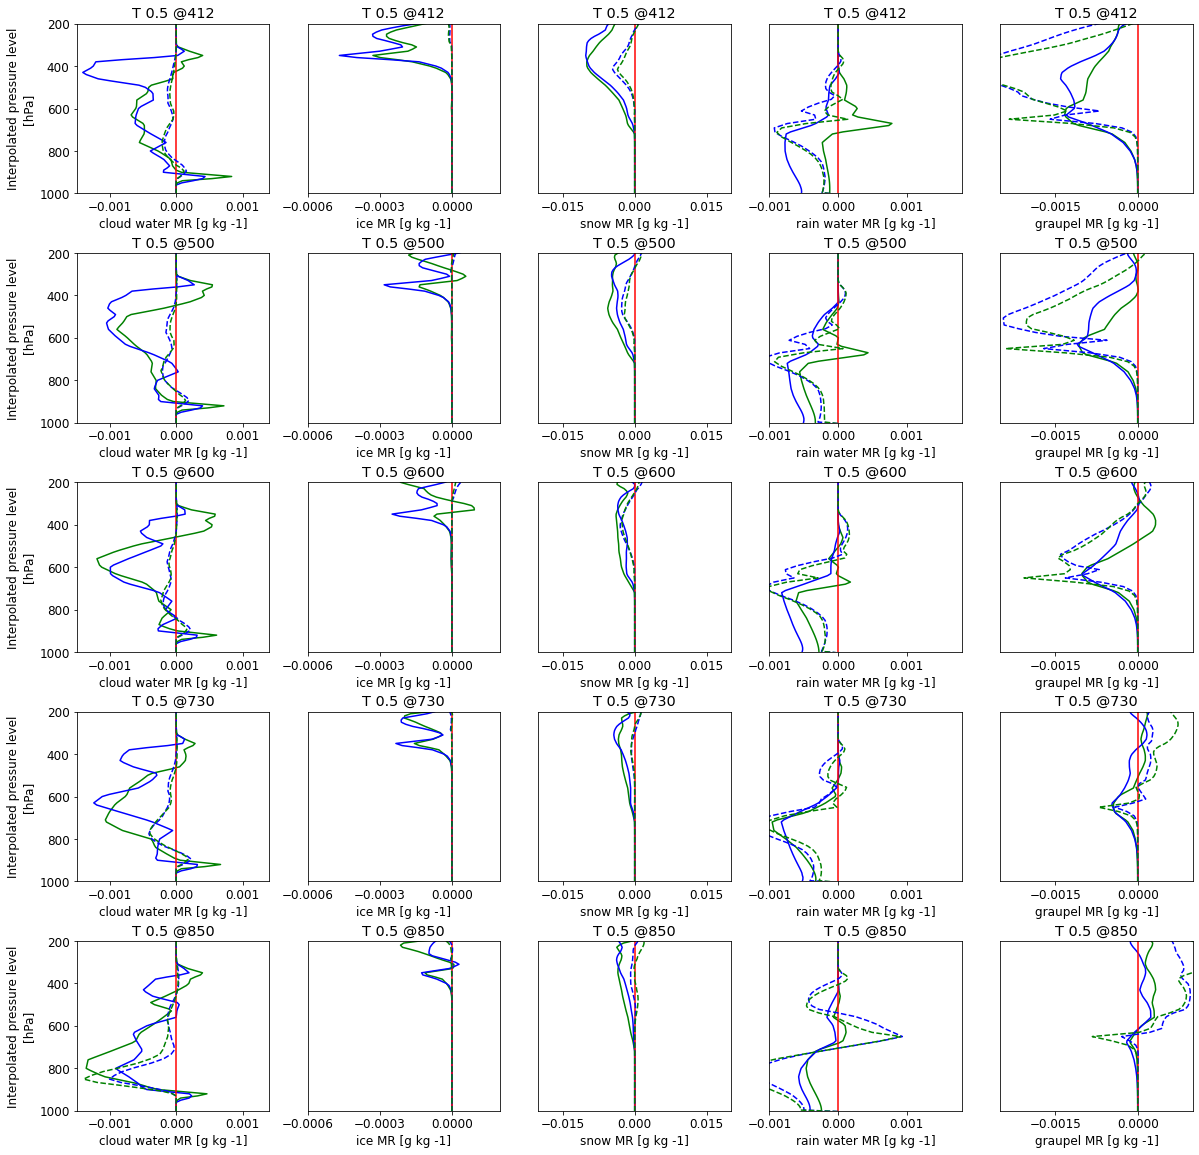

In [125]:
responses_grid(diffs=diffs, comp=chimene,
               pos_perts=['T 0.5 @850',  'T 0.5 @730',  'T 0.5 @600',  'T 0.5 @500',  'T 0.5 @412'][::-1],
               neg_perts=['T -0.5 @850', 'T -0.5 @730', 'T -0.5 @600', 'T -0.5 @500', 'T -0.5 @412'][::-1], 
               variables=['qcloud', 'qice', 'qsnow', 'qrain', 'qgraup'], figsize=(20,20))

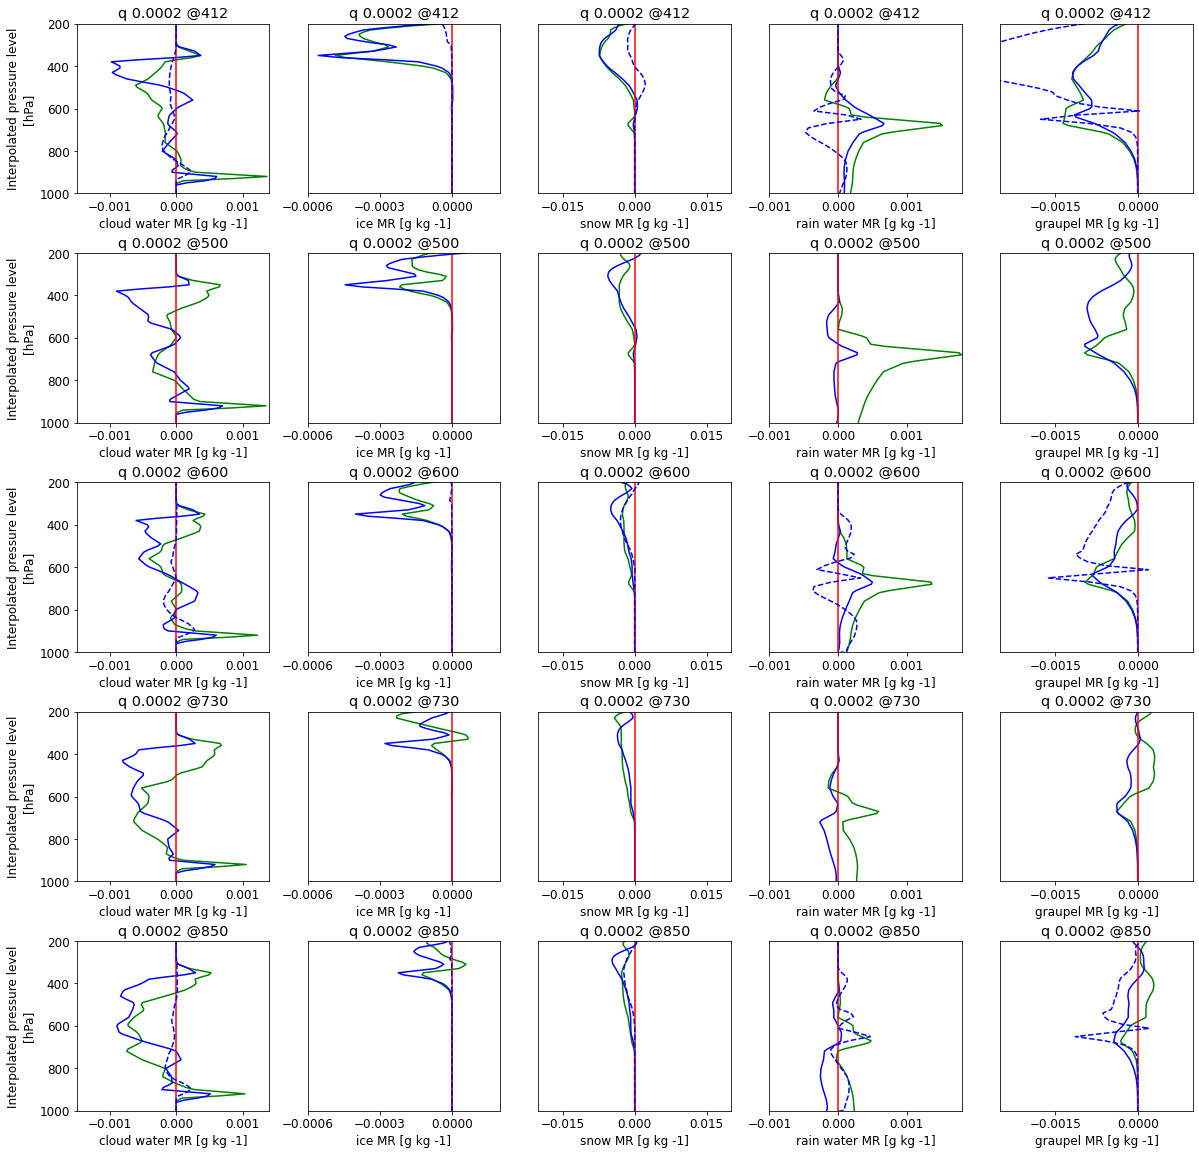

In [126]:
responses_grid(diffs=diffs, comp=chimene,
               pos_perts=['q 0.0002 @850',  'q 0.0002 @730', 'q 0.0002 @600',   'q 0.0002 @500',  'q 0.0002 @412'][::-1], 
               neg_perts=['q -0.0002 @850', 'q -0.0002 @730', 'q -0.0002 @600', 'q -0.0002 @500', 'q -0.0002 @412'][::-1],
               variables=['qcloud', 'qice', 'qsnow', 'qrain', 'qgraup'], figsize=(20,20))

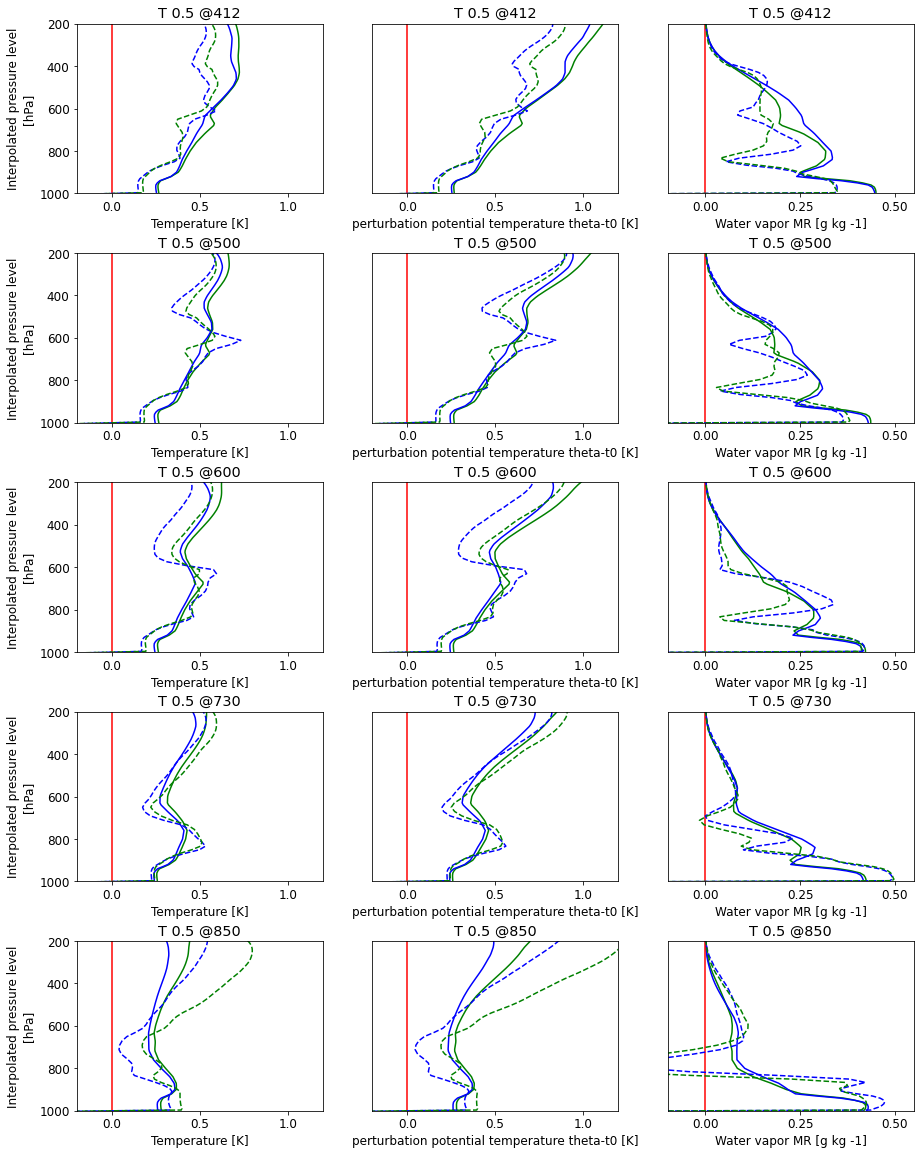

In [127]:
responses_grid(diffs=diffs, comp=chimene,
               pos_perts=['T 0.5 @850',  'T 0.5 @730',  'T 0.5 @600',  'T 0.5 @500',  'T 0.5 @412'][::-1],
               neg_perts=['T -0.5 @850', 'T -0.5 @730', 'T -0.5 @600', 'T -0.5 @500', 'T -0.5 @412'][::-1], 
               variables=['tk', 'T', 'q'], figsize=(15,20))

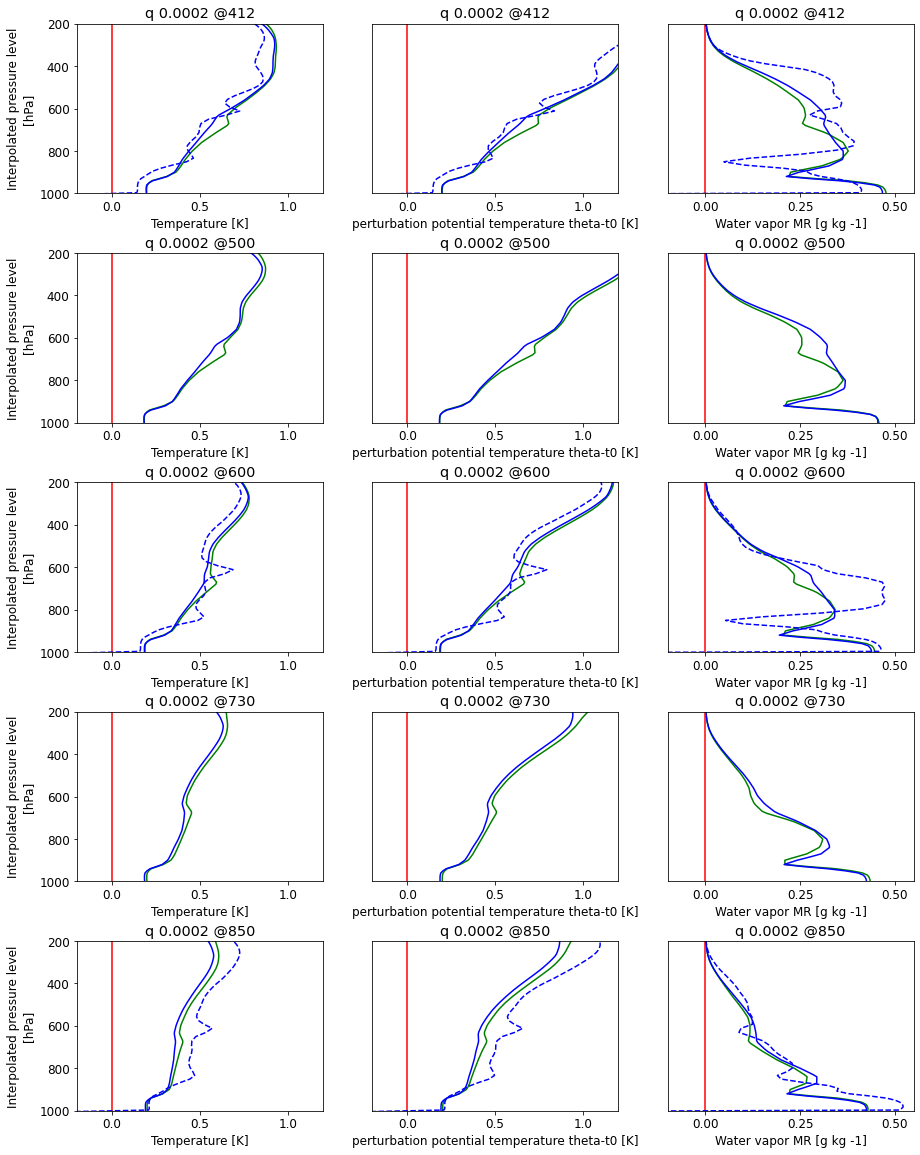

In [128]:
responses_grid(diffs=diffs, comp=chimene,
               pos_perts=['q 0.0002 @850',  'q 0.0002 @730', 'q 0.0002 @600',   'q 0.0002 @500',  'q 0.0002 @412'][::-1], 
               neg_perts=['q -0.0002 @850', 'q -0.0002 @730', 'q -0.0002 @600', 'q -0.0002 @500', 'q -0.0002 @412'][::-1],
               variables=['tk', 'T', 'q'], figsize=(15,20))

## Extra notes

### WRF versions

- RCE runs were all made using a version of WRF in which:
     - Wind damping on $U$ and $V$ was to zero over the whole vertical column with a damping timescale of 4 days.
     - The wind tendencies `RURELAXTEN` and `RVRELAXTEN` were not properly added to the `halo` and `period` definitions, so incorrect values may have been used in the code that adds a staggered tendency field to an unstaggered tendency field (`add_a2c_u` and `add_a2c_v`). 
 
- All other runs (control and perturbations) were made using an updated version in which
     - Wind damping is applied with a three hour time scale above 100 hPa, decreasing to no damping below 160 hPa, except in wind shear case when wind shear is enforced by relaxing winds to shear profiles over the whole vertical column, with a three hour time scale.
     
- For LES RCE run, the initial profile and RCE profile to which stratospheric q is nudged are based on the 1 km RCE run from `2000-03-25` to `2000-03-31` (7 days at the end of the RCE run).